Epoch 1: 100%|██████████| 498/498 [02:31<00:00,  3.29it/s]


E1: train DICE 0.6806 | val DICE 0.7159


Epoch 2: 100%|██████████| 498/498 [02:30<00:00,  3.30it/s]


E2: train DICE 0.7254 | val DICE 0.7403


Epoch 3: 100%|██████████| 498/498 [02:31<00:00,  3.30it/s]


E3: train DICE 0.7431 | val DICE 0.7588


Epoch 4: 100%|██████████| 498/498 [02:30<00:00,  3.30it/s]


E4: train DICE 0.7583 | val DICE 0.7634


Epoch 5: 100%|██████████| 498/498 [02:31<00:00,  3.29it/s]


E5: train DICE 0.7807 | val DICE 0.7841


Epoch 6: 100%|██████████| 498/498 [02:31<00:00,  3.29it/s]


E6: train DICE 0.7898 | val DICE 0.7872


Epoch 7: 100%|██████████| 498/498 [02:31<00:00,  3.29it/s]


E7: train DICE 0.7978 | val DICE 0.7956


Epoch 8: 100%|██████████| 498/498 [02:32<00:00,  3.27it/s]


E8: train DICE 0.8049 | val DICE 0.8088


Epoch 9: 100%|██████████| 498/498 [02:32<00:00,  3.27it/s]


E9: train DICE 0.8122 | val DICE 0.7770


Epoch 10: 100%|██████████| 498/498 [02:31<00:00,  3.28it/s]


E10: train DICE 0.8137 | val DICE 0.8262


Epoch 11: 100%|██████████| 498/498 [02:32<00:00,  3.27it/s]


E11: train DICE 0.8223 | val DICE 0.8203


Epoch 12: 100%|██████████| 498/498 [02:31<00:00,  3.29it/s]


E12: train DICE 0.8267 | val DICE 0.8053


Epoch 13: 100%|██████████| 498/498 [02:31<00:00,  3.29it/s]


E13: train DICE 0.8274 | val DICE 0.8075
Test Dice 0.8037 | IoU 0.6845


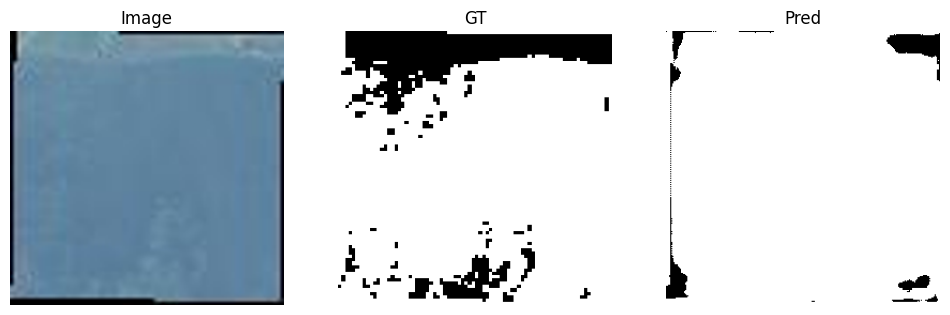

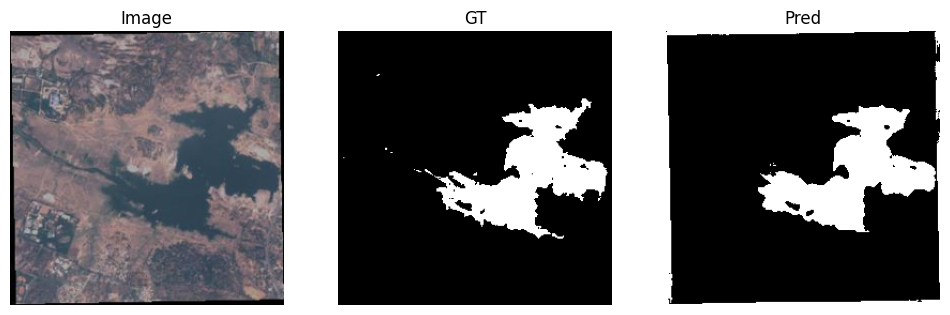

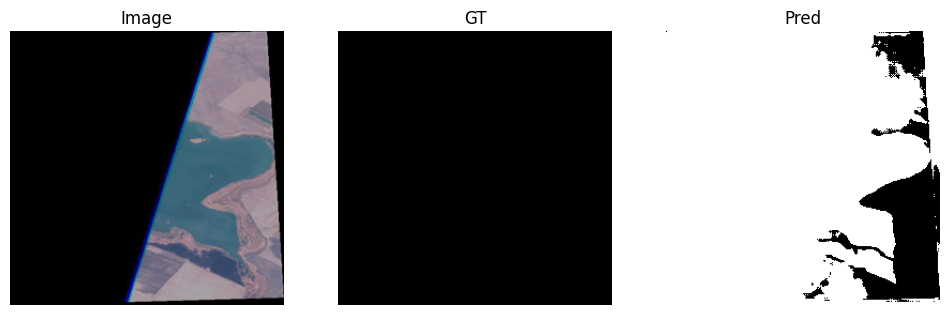

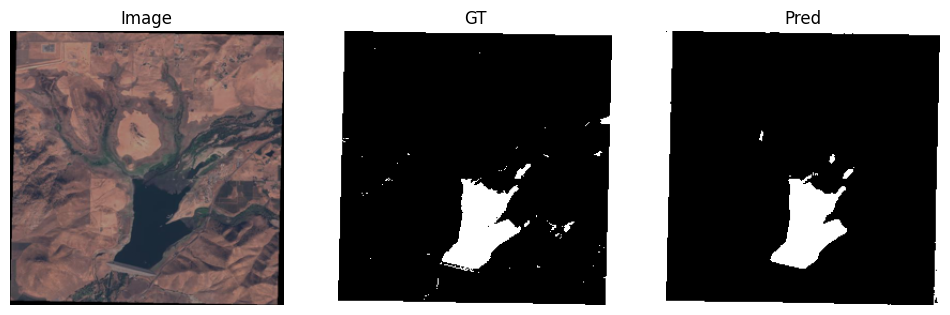

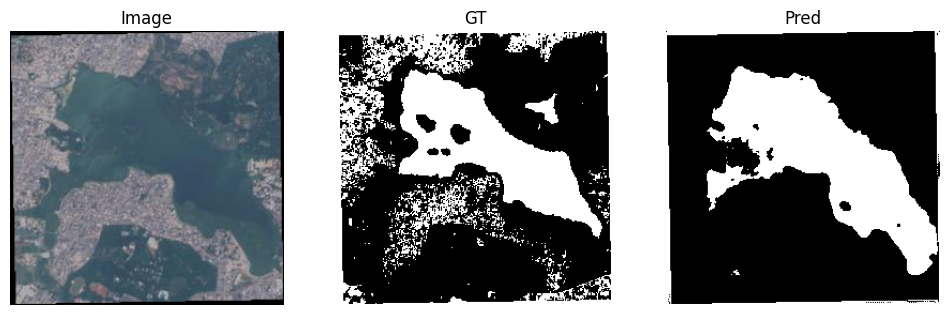

In [6]:
# ---------------------------------------------------------------
# Water-body segmentation with Small-World U-Net
# ---------------------------------------------------------------
import os, glob, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------------
# Dataset
# ---------------------------------------------------------------
class SatelliteDataset(Dataset):
    def __init__(self, image_dirs, mask_dirs):
        self.image_mask_pairs = []
        for img_dir, mask_dir in zip(image_dirs, mask_dirs):
            for ipath in sorted(glob.glob(os.path.join(img_dir, "*.jpg"))):
                fname = os.path.splitext(os.path.basename(ipath))[0]
                mpath = os.path.join(mask_dir, fname + ".jpg")
                if os.path.exists(mpath):
                    self.image_mask_pairs.append((ipath, mpath))

    def __len__(self): return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        ipath, mpath = self.image_mask_pairs[idx]
        img  = Image.open(ipath).convert("RGB").resize((256,256))
        mask = Image.open(mpath).convert("L" ).resize((256,256), Image.NEAREST)
        img  = T.ToTensor()(img)
        mask = (T.ToTensor()(mask) > 0.5).float()
        return img, mask

# ---------------------------------------------------------------
# Model components
# ---------------------------------------------------------------
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc1 = nn.Sequential(CBR(3, 64), CBR(64, 64))
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.enc3 = nn.Sequential(CBR(128, 256), CBR(256, 256))
        self.enc4 = nn.Sequential(CBR(256, 512), CBR(512, 512))
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(CBR(512, 1024), CBR(1024, 1024))

        # Decoder
        self.up3 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = nn.Sequential(CBR(1024, 512), CBR(512, 512))

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = nn.Sequential(CBR(512, 256), CBR(256, 256))

        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.Sequential(CBR(256, 128), CBR(128, 128))

        self.up0 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Sequential(CBR(128, 64), CBR(64, 64))

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder
        d4 = self.dec4(torch.cat([self.up3(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up2(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up1(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up0(d2), e1], dim=1))

        return self.final(d1)

# ---------------------------------------------------------------
# Metrics
# ---------------------------------------------------------------
def dice_coefficient(pred, target, eps=1e-6):
    pred, target = pred.view(-1), target.view(-1)
    inter = (pred*target).sum()
    return (2*inter+eps)/(pred.sum()+target.sum()+eps)
def iou_score(pred, target, eps=1e-6):
    pred, target = pred.view(-1), target.view(-1)
    inter = (pred*target).sum()
    return (inter+eps)/(pred.sum()+target.sum()-inter+eps)

# ---------------------------------------------------------------
# Train / evaluate
# ---------------------------------------------------------------
def train_model(image_dirs, mask_dirs):
    ds = SatelliteDataset(image_dirs, mask_dirs)
    assert len(ds)==2841, f"Dataset size mismatch: {len(ds)}"

    tr,val,te = random_split(ds, [1989,568,2841-1989-568])
    tr_ld = DataLoader(tr, batch_size=4, shuffle=True, num_workers=0)
    vl_ld = DataLoader(val, batch_size=4, shuffle=False, num_workers=0)
    te_ld = DataLoader(te, batch_size=4, shuffle=False, num_workers=0)


    net = UNet().to(device)
    opt = torch.optim.Adam(net.parameters(), lr=1e-4)
    crit= nn.BCEWithLogitsLoss()

    best, wait, patience = 0,0,3
    for ep in range(15):
        # train
        net.train(); tl=td=0
        for x,y in tqdm(tr_ld, desc=f"Epoch {ep+1}"):
            x,y=x.to(device),y.to(device)
            log = net(x); loss=crit(log,y)
            opt.zero_grad(); loss.backward(); opt.step()
            tl += loss.item()
            td += dice_coefficient((torch.sigmoid(log)>0.5).float(), y).item()
        td/=len(tr_ld)

        # val
        net.eval(); vd=0
        with torch.no_grad():
            for x,y in vl_ld:
                x,y=x.to(device),y.to(device)
                p = (torch.sigmoid(net(x))>0.5).float()
                vd += dice_coefficient(p,y).item()
        vd/=len(vl_ld)
        print(f"E{ep+1}: train DICE {td:.4f} | val DICE {vd:.4f}")
        if vd>best: best,wait=vd,0; torch.save(net.state_dict(),"best.pth")
        else:
            wait+=1
            if wait>=patience: break

    net.load_state_dict(torch.load("best.pth"))
    # test
    net.eval(); d=i=0
    with torch.no_grad():
        for x,y in te_ld:
            x,y=x.to(device),y.to(device)
            p=(torch.sigmoid(net(x))>0.5).float()
            d+=dice_coefficient(p,y).item()
            i+=iou_score(p,y).item()
    n=len(te_ld)
    print(f"Test Dice {d/n:.4f} | IoU {i/n:.4f}")
    return net,val,te

# ---------------------------------------------------------------
# Visualisation
# ---------------------------------------------------------------
def visualize(net,dset,n=3):
    net.eval()
    for k in range(min(n,len(dset))):
        img,msk=dset[k]
        with torch.no_grad():
            p=(torch.sigmoid(net(img.unsqueeze(0).to(device))).squeeze().cpu()>0.5).numpy()
        fig,ax=plt.subplots(1,3,figsize=(12,4))
        ax[0].imshow(img.permute(1,2,0)); ax[0].set_title("Image")
        ax[1].imshow(msk.squeeze(),cmap='gray'); ax[1].set_title("GT")
        ax[2].imshow(p,cmap='gray'); ax[2].set_title("Pred")
        for a in ax: a.axis("off")
        plt.show()

# ---------------------------------------------------------------
# Entry-point
# ---------------------------------------------------------------
if __name__=="__main__":
    base="/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split"
    img_dirs =[os.path.join(base,"train_images"),os.path.join(base,"valid_images")]
    msk_dirs =[os.path.join(base,"train_masks"),os.path.join(base,"valid_masks")]

    net,val_set,test_set = train_model(img_dirs,msk_dirs)
    visualize(net,val_set,3)
    visualize(net,test_set,2)